In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import upsetplot

In [2]:
gen_a_df = pd.read_csv(
    "/home/st-gorbatovski/sollama/data/processed/tanh_score/python_basics/hand_check/from_db/gen_a.csv",
    lineterminator="\n",
)
qa_df = pd.read_csv(
    "/home/st-gorbatovski/sollama/data/processed/tanh_score/python_basics/hand_check/from_db/qa.csv",
    lineterminator="\n",
)
ratings_df = pd.read_csv(
    "/home/st-gorbatovski/sollama/data/processed/tanh_score/python_basics/hand_check/from_db/ratings.csv",
    lineterminator="\n",
)

In [4]:
base_df = pd.read_csv(
    "/home/st-gorbatovski/sollama/data/processed/tanh_score/python_basics/hand_check/test-base_llama-7b-bs_64-basics-t_09-3_attepmts_1.csv",
    lineterminator="\n",
)

sft_so_df = pd.read_csv(
    "/home/st-gorbatovski/sollama/data/processed/tanh_score/python_basics/hand_check/test-LoRA_llama-7b-bs_64-lr_1e4-basics-no_zero-v4-t_09-3_attepmts-merged_2.csv",
    lineterminator="\n",
)

rlhf_df = pd.read_csv(
    "/home/st-gorbatovski/sollama/data/processed/tanh_score/python_basics/hand_check/test-rlhf-LoRA_llama-7b-t_09-basics-mpnet_dot_prod_so_par-cos_sim-length_penalty-step_261-mean_reward_0.48-3_attempts_3.csv",
    lineterminator="\n",
)

sft_so_par_df = pd.read_csv(
    "/home/st-gorbatovski/sollama/data/processed/tanh_score/python_basics/hand_check/test-sft-LoRA_llama-7b-max_prompt_length_512-t_09-basics-paraphrased-3_attempts_4.csv",
    lineterminator="\n",
)

In [5]:
merged_data = ratings_df.merge(gen_a_df, on="gen_id").merge(qa_df, on="qa_id")

In [6]:
file_to_csv_id = {
    "test-sft-LoRA_llama-7b-max_prompt_length_512-t_09-basics-paraphrased-3_attempts_4.csv": 4,
    "test-rlhf-LoRA_llama-7b-t_09-basics-mpnet_dot_prod_so_par-cos_sim-length_penalty-step_261-mean_reward_0.48-3_attempts_3.csv": 3,
    "test-base_llama-7b-bs_64-basics-t_09-3_attepmts_1.csv": 1,
    "test-LoRA_llama-7b-bs_64-lr_1e4-basics-no_zero-v4-t_09-3_attepmts-merged_2.csv": 2
}

file_to_type = {
    "test-sft-LoRA_llama-7b-max_prompt_length_512-t_09-basics-paraphrased-3_attempts_4.csv": "sft_so_par",
    "test-rlhf-LoRA_llama-7b-t_09-basics-mpnet_dot_prod_so_par-cos_sim-length_penalty-step_261-mean_reward_0.48-3_attempts_3.csv": "rlfh",
    "test-base_llama-7b-bs_64-basics-t_09-3_attepmts_1.csv": "base",
    "test-LoRA_llama-7b-bs_64-lr_1e4-basics-no_zero-v4-t_09-3_attepmts-merged_2.csv": "sft_so"
}

In [47]:
merged_dfs = {}
columns_to_keep = ['rating_value', 'relevance', 'correctness', 'usefulness', 'justification']

# Merge each long-named CSV with merged_data using csv_id
for file, csv_id in file_to_csv_id.items():
    # Read the long-named CSV file
    long_named_df = pd.read_csv(
        f"/home/st-gorbatovski/sollama/data/processed/tanh_score/python_basics/hand_check/{file}"
    )

    # Merge with merged_data on csv_id and q_id/Q_Id
    merged_df = long_named_df.merge(
        merged_data[merged_data["csv_id"] == csv_id],
        left_on=["Gen_Q_Id", "Q_Id"],
        right_on=["csv_gen_id", "q_id"],
        how="left",
    )

    # Keep only the necessary columns
    merged_df = merged_df[list(long_named_df.columns) + columns_to_keep]

    # Store the merged dataframe in merged_dfs dictionary
    merged_dfs[file_to_type[file]] = merged_df

In [48]:
print(merged_dfs.keys())

dict_keys(['sft_so_par', 'rlfh', 'base', 'sft_so'])


In [49]:
base = merged_dfs["base"][~merged_dfs["base"].relevance.isna()]
sft_so = merged_dfs["sft_so"][~merged_dfs["sft_so"].relevance.isna()]
sft_so_par = merged_dfs["sft_so_par"][~merged_dfs["sft_so_par"].relevance.isna()]
rlhf = merged_dfs["rlfh"][~merged_dfs["rlfh"].relevance.isna()]

In [50]:
base_rank_1 = base[base.rating_value == 1].reset_index(drop=True)
sft_so_rank_1 = sft_so[sft_so.rating_value == 1].reset_index(drop=True)
sft_so_par_rank_1 = sft_so_par[sft_so_par.rating_value == 1].reset_index(drop=True)
rlhf_rank_1 = rlhf[rlhf.rating_value == 1].reset_index(drop=True)

In [39]:
len(rlhf) == len(sft_so) == len(base) == len(sft_so_par)

True

In [28]:
from upsetplot import UpSet, from_indicators

In [29]:
bin_columns = ["relevance", "correctness", "usefulness", "justification"]

## Helpers

In [52]:
import pandas as pd
import numpy as np
from scipy.stats import rankdata
from scipy.signal import decimate
import math
import time
import matplotlib.pyplot as plt
from sklearn.preprocessing import KBinsDiscretizer
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

def hoeffding(*arg):
  
    if(len(arg)==1):
      if isinstance(arg[0], pd.DataFrame):
        if(arg[0].shape[0]>1):
          return arg[0].apply(lambda x: arg[0].apply(lambda y: hoeffding(x.values, y.values)))
    else:
      if(len(arg)==2):
        if type(arg[0]) is not np.ndarray:
          if (len(arg[0].shape)>1):
            return print("ERROR inputs : hoeffding(df >2col) or hoeffding(numpy.array -1d- ,numpy.array -1d-)")
        if type(arg[1]) is np.ndarray:
          if (len(arg[0].shape)>1):
            return print("ERROR inputs : hoeffding(df >2col) or hoeffding(numpy.array -1d- ,numpy.array -1d-)")
        
        xin=arg[0]
        yin=arg[1]
        #crop data to the smallest array, length have to be equal
        if len(xin)<len(yin):
          yin=yin[:len(xin)]
        if len(xin)>len(yin):
          xin=xin[:len(yin)]

        # dropna
        x = xin[~(np.isnan(xin) | np.isnan(yin))]
        y = yin[~(np.isnan(xin) | np.isnan(yin))]

        # undersampling if length too long
        lenx=len(x)
        if lenx>99999:
            factor=math.ceil(lenx/100000)
            x=x[::factor]
            y=y[::factor]

        # bining if too much "definition"
        if len(np.unique(x))>50:
            est = KBinsDiscretizer(n_bins=50, encode='ordinal', strategy='quantile') #faster strategy='quantile' but less accurate
            est.fit(x.reshape(-1, 1))  
            Rtemp = est.transform(x.reshape(-1, 1))
            R=rankdata(Rtemp)
        else:
            R=rankdata(x)
        if len(np.unique(y))>50:
            est1 = KBinsDiscretizer(n_bins=50, encode='ordinal', strategy='quantile') #faster strategy='quantile' but less accurate
            est1.fit(y.reshape(-1, 1))  
            Stemp = est1.transform(y.reshape(-1, 1))
            S=rankdata(Stemp)
        else:
            S=rankdata(y)      

        # core processing
        N=x.shape
        dico={(np.nan,np.nan):np.nan}
        dicoRin={np.nan:np.nan}
        dicoSin={np.nan:np.nan}
        dicoRless={np.nan:np.nan}
        dicoSless={np.nan:np.nan}
        Q=np.ones(N[0])

        i=0;
        for r,s in np.nditer([R,S]):
            r=float(r)
            s=float(s)
            if (r,s) in dico.keys():
                Q[i]=dico[(r,s)]
            else:
              if r in dicoRin.keys():
                  isinR=dicoRin[r]
                  lessR=dicoRless[r]
              else:
                  isinR=np.isin(R,r)
                  dicoRin[r]=isinR
                  lessR=np.less(R,r)
                  dicoRless[r]=lessR

              if s in dicoSin.keys():
                  isinS=dicoSin[s]
                  lessS=dicoSless[s]
              else:
                  isinS=np.isin(S,s)
                  dicoSin[s]=isinS
                  lessS=np.less(S,s)
                  dicoSless[s]=lessS


              Q[i] = Q[i] + np.count_nonzero(lessR & lessS) \
                    + 1/4 * (np.count_nonzero(isinR & isinS)-1) \
                    + 1/2 * (np.count_nonzero(isinR & lessS)) \
                     + 1/2 * (np.count_nonzero(lessR & isinS)) 
              dico[(r,s)]=Q[i]
            i+=1

        D1 = np.sum( np.multiply((Q-1),(Q-2)) );
        D2 = np.sum( np.multiply(np.multiply((R-1),(R-2)),np.multiply((S-1),(S-2)) ) );
        D3 = np.sum( np.multiply(np.multiply((R-2),(S-2)),(Q-1)) );

        D = 30*((N[0]-2)*(N[0]-3)*D1 + D2 - 2*(N[0]-2)*D3) / (N[0]*(N[0]-1)*(N[0]-2)*(N[0]-3)*(N[0]-4));


        return D
      return print("ERROR inputs : hoeffding(df >2col) or hoeffding(numpy.array -1d- ,numpy.array -1d-)")

In [57]:
import ppscore as pps
import seaborn as sns
from minepy import MINE
from scipy.spatial.distance import correlation
from scipy.stats import pearsonr, spearmanr, kendalltau
from sklearn.feature_selection import mutual_info_regression

In [67]:
def compute_rank_correlations(df, metric1, metric2):
    grouped_data = df.groupby('Q_Id')
    rank1 = grouped_data[metric1].rank(method='min', ascending=False)
    rank2 = grouped_data[metric2].rank(method='min', ascending=False)
    
    corr_spearman, _ = spearmanr(rank1, rank2)
    corr_kendall, _ = kendalltau(rank1, rank2)
    return corr_spearman, corr_kendall

def calculate_mic(x, y):
    mine = MINE()
    mine.compute_score(x, y)
    return mine.mic()

def calculate_correlation_distance(x, y):
    return correlation(x, y)

def calculate_hoeffdings_d(x, y):
    return hoeffding(x.values, y.values)

def calculate_advanced_correlations(df, predicted_metrics, linguistic_metrics):
    advanced_correlations = {}
    for pred_metric in predicted_metrics:
        advanced_correlations[pred_metric] = {}
        for ling_metric in linguistic_metrics:
            x = df[pred_metric]
            y = df[ling_metric]
            mic = calculate_mic(x, y)
            corr_dist = calculate_correlation_distance(x, y)
            hoeff_d = calculate_hoeffdings_d(x, y)
            advanced_correlations[pred_metric][ling_metric] = {
                'MIC': mic,
                'Correlation Distance': corr_dist,
                'Hoeffding\'s D': hoeff_d
            }
    return advanced_correlations

def calculate_pps(df, predicted_metrics, linguistic_metrics):
    pps_scores = {}
    for pred_metric in predicted_metrics:
        pps_scores[pred_metric] = {}
        for ling_metric in linguistic_metrics:
            score = pps.score(df, ling_metric, pred_metric)
            pps_scores[pred_metric][ling_metric] = score['ppscore']
    return pps_scores


def calculate_correlations_and_mi(df, predicted_metrics, linguistic_metrics):
    # Calculate correlations
    correlations = {}
    for pred_metric in predicted_metrics:
        correlations[pred_metric] = {}
        for ling_metric in linguistic_metrics:
            pearson_corr, _ = pearsonr(df[pred_metric], df[ling_metric])
            spearman_corr, _ = spearmanr(df[pred_metric], df[ling_metric])
            correlations[pred_metric][ling_metric] = {
                'Pearson': pearson_corr,
                'Spearman': spearman_corr
            }

    # Calculate mutual information
    mutual_infos = {}
    for pred_metric in predicted_metrics:
        mutual_infos[pred_metric] = {}
        for ling_metric in linguistic_metrics:
            mi = mutual_info_regression(df[pred_metric].values.reshape(-1, 1), df[ling_metric])
            mutual_infos[pred_metric][ling_metric] = mi[0]
    
    return correlations, mutual_infos

def calculate_rank_correlations(df, predicted_metrics, linguistic_metrics):
    # Calculate rank correlations for all metric combinations
    rank_correlations = {}
    for pred_metric in predicted_metrics:
        rank_correlations[pred_metric] = {}
        for ling_metric in linguistic_metrics:
            spearman_corr, kendall_corr = compute_rank_correlations(df, ling_metric, pred_metric)
            rank_correlations[pred_metric][ling_metric] = {
                'Spearman': spearman_corr,
                'Kendall': kendall_corr
            }
    return rank_correlations

def visualize_results(correlations, mutual_infos, rank_correlations, pps_res, advanced_correlations):
    # Extracting data for heatmap
    pearson_df = pd.DataFrame({k: {i: v['Pearson'] for i, v in val.items()} for k, val in correlations.items()})
    spearman_df = pd.DataFrame({k: {i: v['Spearman'] for i, v in val.items()} for k, val in correlations.items()})
    mi_df = pd.DataFrame(mutual_infos)
    spearman_rank_df = pd.DataFrame({k: {i: v['Spearman'] for i, v in val.items()} for k, val in rank_correlations.items()})
    kendall_rank_df = pd.DataFrame({k: {i: v['Kendall'] for i, v in val.items()} for k, val in rank_correlations.items()})
    pps_df = pd.DataFrame(pps_res)
    mic_df = pd.DataFrame({k: {i: v['MIC'] for i, v in val.items()} for k, val in advanced_correlations.items()})
    corr_dist_df = pd.DataFrame({k: {i: v['Correlation Distance'] for i, v in val.items()} for k, val in advanced_correlations.items()})
    hoeff_d_df = pd.DataFrame({k: {i: v['Hoeffding\'s D'] for i, v in val.items()} for k, val in advanced_correlations.items()})


    # Visualization with subplots
    fig, axs = plt.subplots(3, 3, figsize=(18, 15))
    fig.suptitle('Correlations and Mutual Information', fontsize=16, y=1.05)

    sns.heatmap(pearson_df, annot=True, cmap='coolwarm', center=0, vmin=-1, vmax=1, ax=axs[0, 0])
    axs[0, 0].set_title('Pearson Correlation')

    sns.heatmap(spearman_df, annot=True, cmap='coolwarm', center=0, vmin=-1, vmax=1, ax=axs[0, 1])
    axs[0, 1].set_title('Spearman Correlation')

    sns.heatmap(mi_df, annot=True, cmap='coolwarm', center=0, vmin=0, vmax=0.05, ax=axs[0, 2])
    axs[0, 2].set_title('Mutual Information')

    sns.heatmap(spearman_rank_df, annot=True, cmap='coolwarm', center=0, vmin=-1, vmax=1, ax=axs[1, 0])
    axs[1, 0].set_title('Rank-based Spearman Correlation')

    sns.heatmap(kendall_rank_df, annot=True, cmap='coolwarm', center=0, vmin=-1, vmax=1, ax=axs[1, 1])
    axs[1, 1].set_title('Rank-based Kendall Correlation')

    sns.heatmap(pps_df, annot=True, cmap='coolwarm', center=0, vmin=0, vmax=1, ax=axs[1, 2])
    axs[1, 2].set_title('PPS')

    sns.heatmap(mic_df, annot=True, cmap='coolwarm', center=0, vmin=0, vmax=1, ax=axs[2, 0])
    axs[2, 0].set_title('MIC')
    sns.heatmap(corr_dist_df, annot=True, cmap='coolwarm', center=0, vmin=0, vmax=1, ax=axs[2, 1])
    axs[2, 1].set_title('Correlation Distance')
    sns.heatmap(hoeff_d_df, annot=True, cmap='coolwarm', center=0, vmin=0, vmax=1, ax=axs[2, 2])
    axs[2, 2].set_title('Hoeffding\'s D')

    plt.tight_layout()
    plt.show()

def analyze_metrics(df, predicted_metrics, linguistic_metrics):
    correlations, mutual_infos = calculate_correlations_and_mi(df, predicted_metrics, linguistic_metrics)
    rank_correlations = calculate_rank_correlations(df, predicted_metrics, linguistic_metrics)
    pps_res = calculate_pps(df, predicted_metrics, linguistic_metrics)
    advanced_correlations = calculate_advanced_correlations(df, predicted_metrics, linguistic_metrics)
    visualize_results(correlations, mutual_infos, rank_correlations, pps_res, advanced_correlations)


## Evaluation

In [60]:
base.columns

Index(['Question', 'Answer', 'Title', 'Score', 'Users Score', 'Q_Id',
       'CreationDate', 'log_score', 'Gen_Q_Id', 'Generated Answer', 'ROUGE_1',
       'ROUGE_2', 'ROUGE_L', 'BLEU', 'BERT Score', 'dot_prod_gen',
       'cos_sim_gen', 'euclidean_gen', 'rating_value', 'relevance',
       'correctness', 'usefulness', 'justification'],
      dtype='object')

In [66]:
# Test the function with the given metrics
predicted_metrics = [
    "dot_prod_gen",
    "cos_sim_gen",
    "euclidean_gen",
    "ROUGE_1",
    "ROUGE_2",
    "ROUGE_L",
    "BLEU",
    "BERT Score",
]
linguistic_metrics = [
    "rating_value",
    "relevance",
    "correctness",
    "usefulness",
    "justification",
]

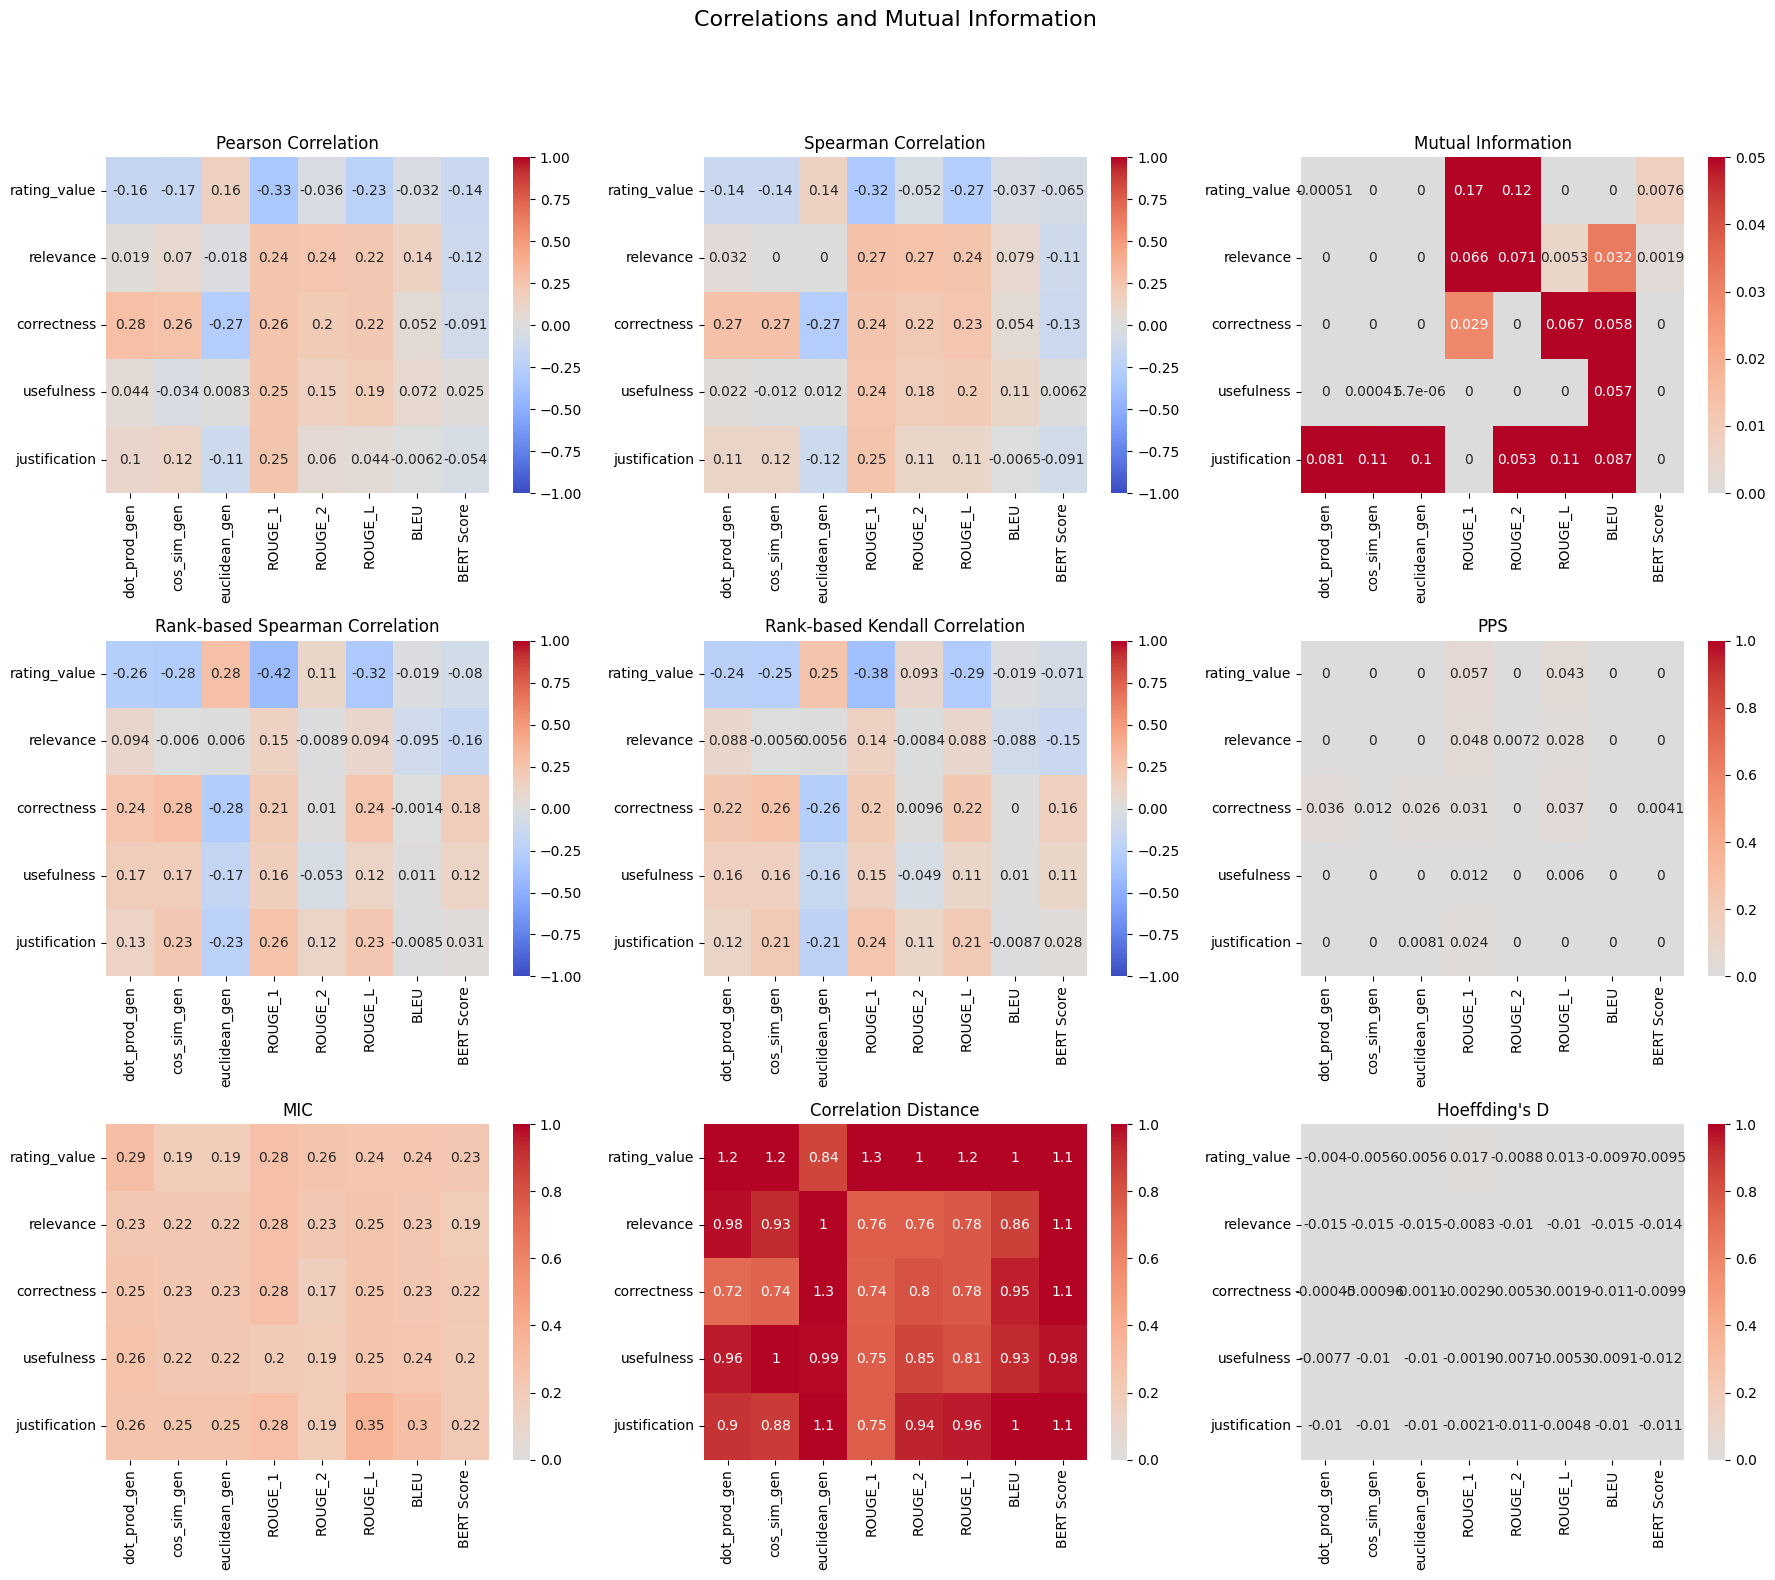

In [68]:
analyze_metrics(base, predicted_metrics, linguistic_metrics)

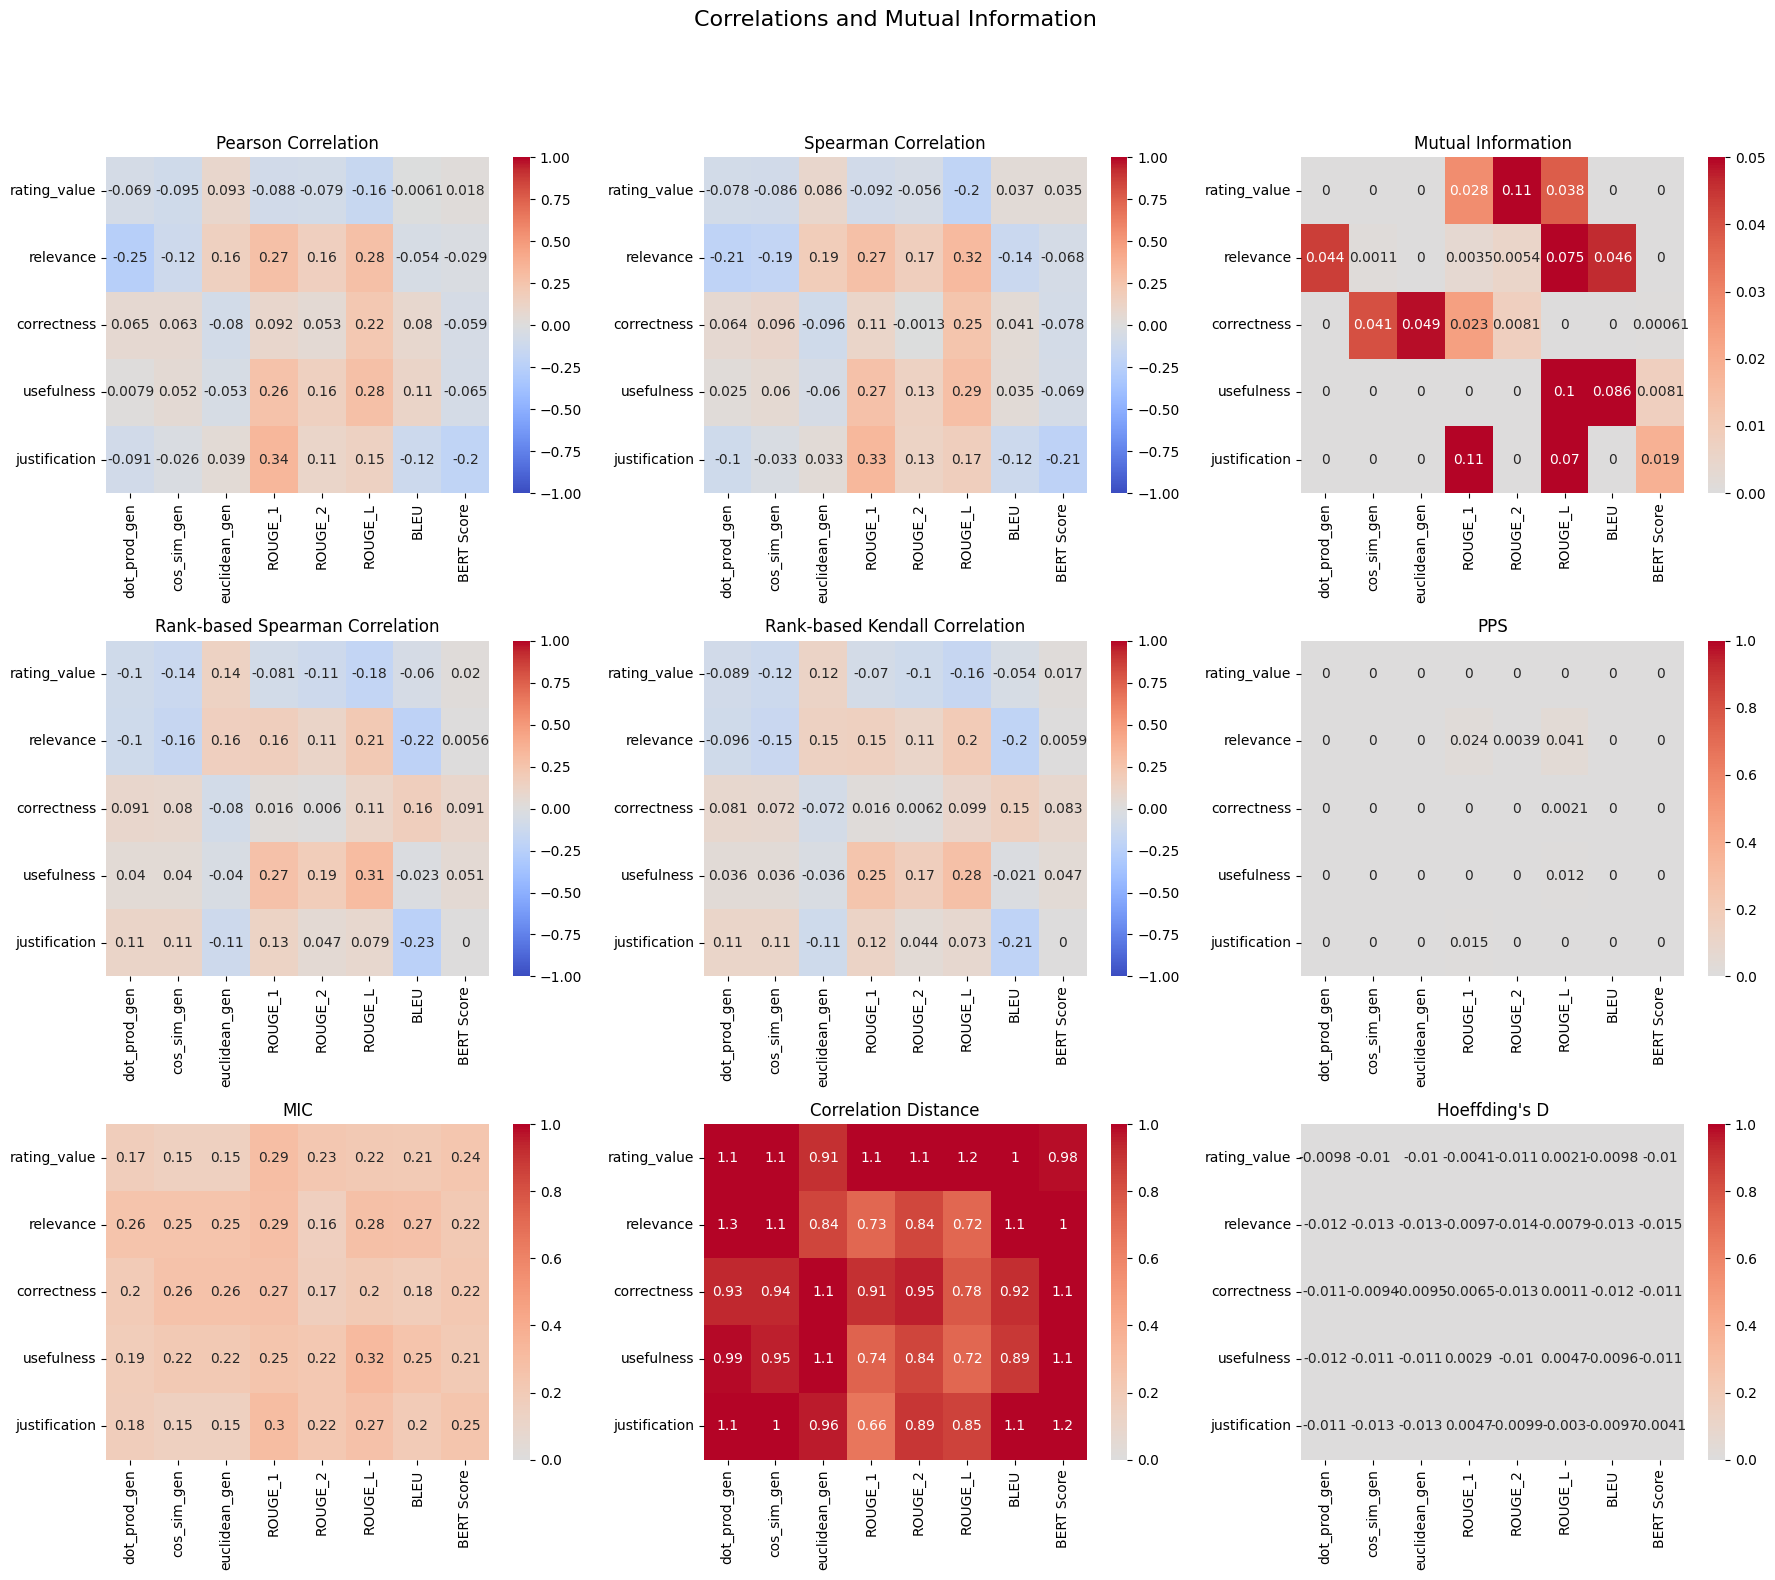

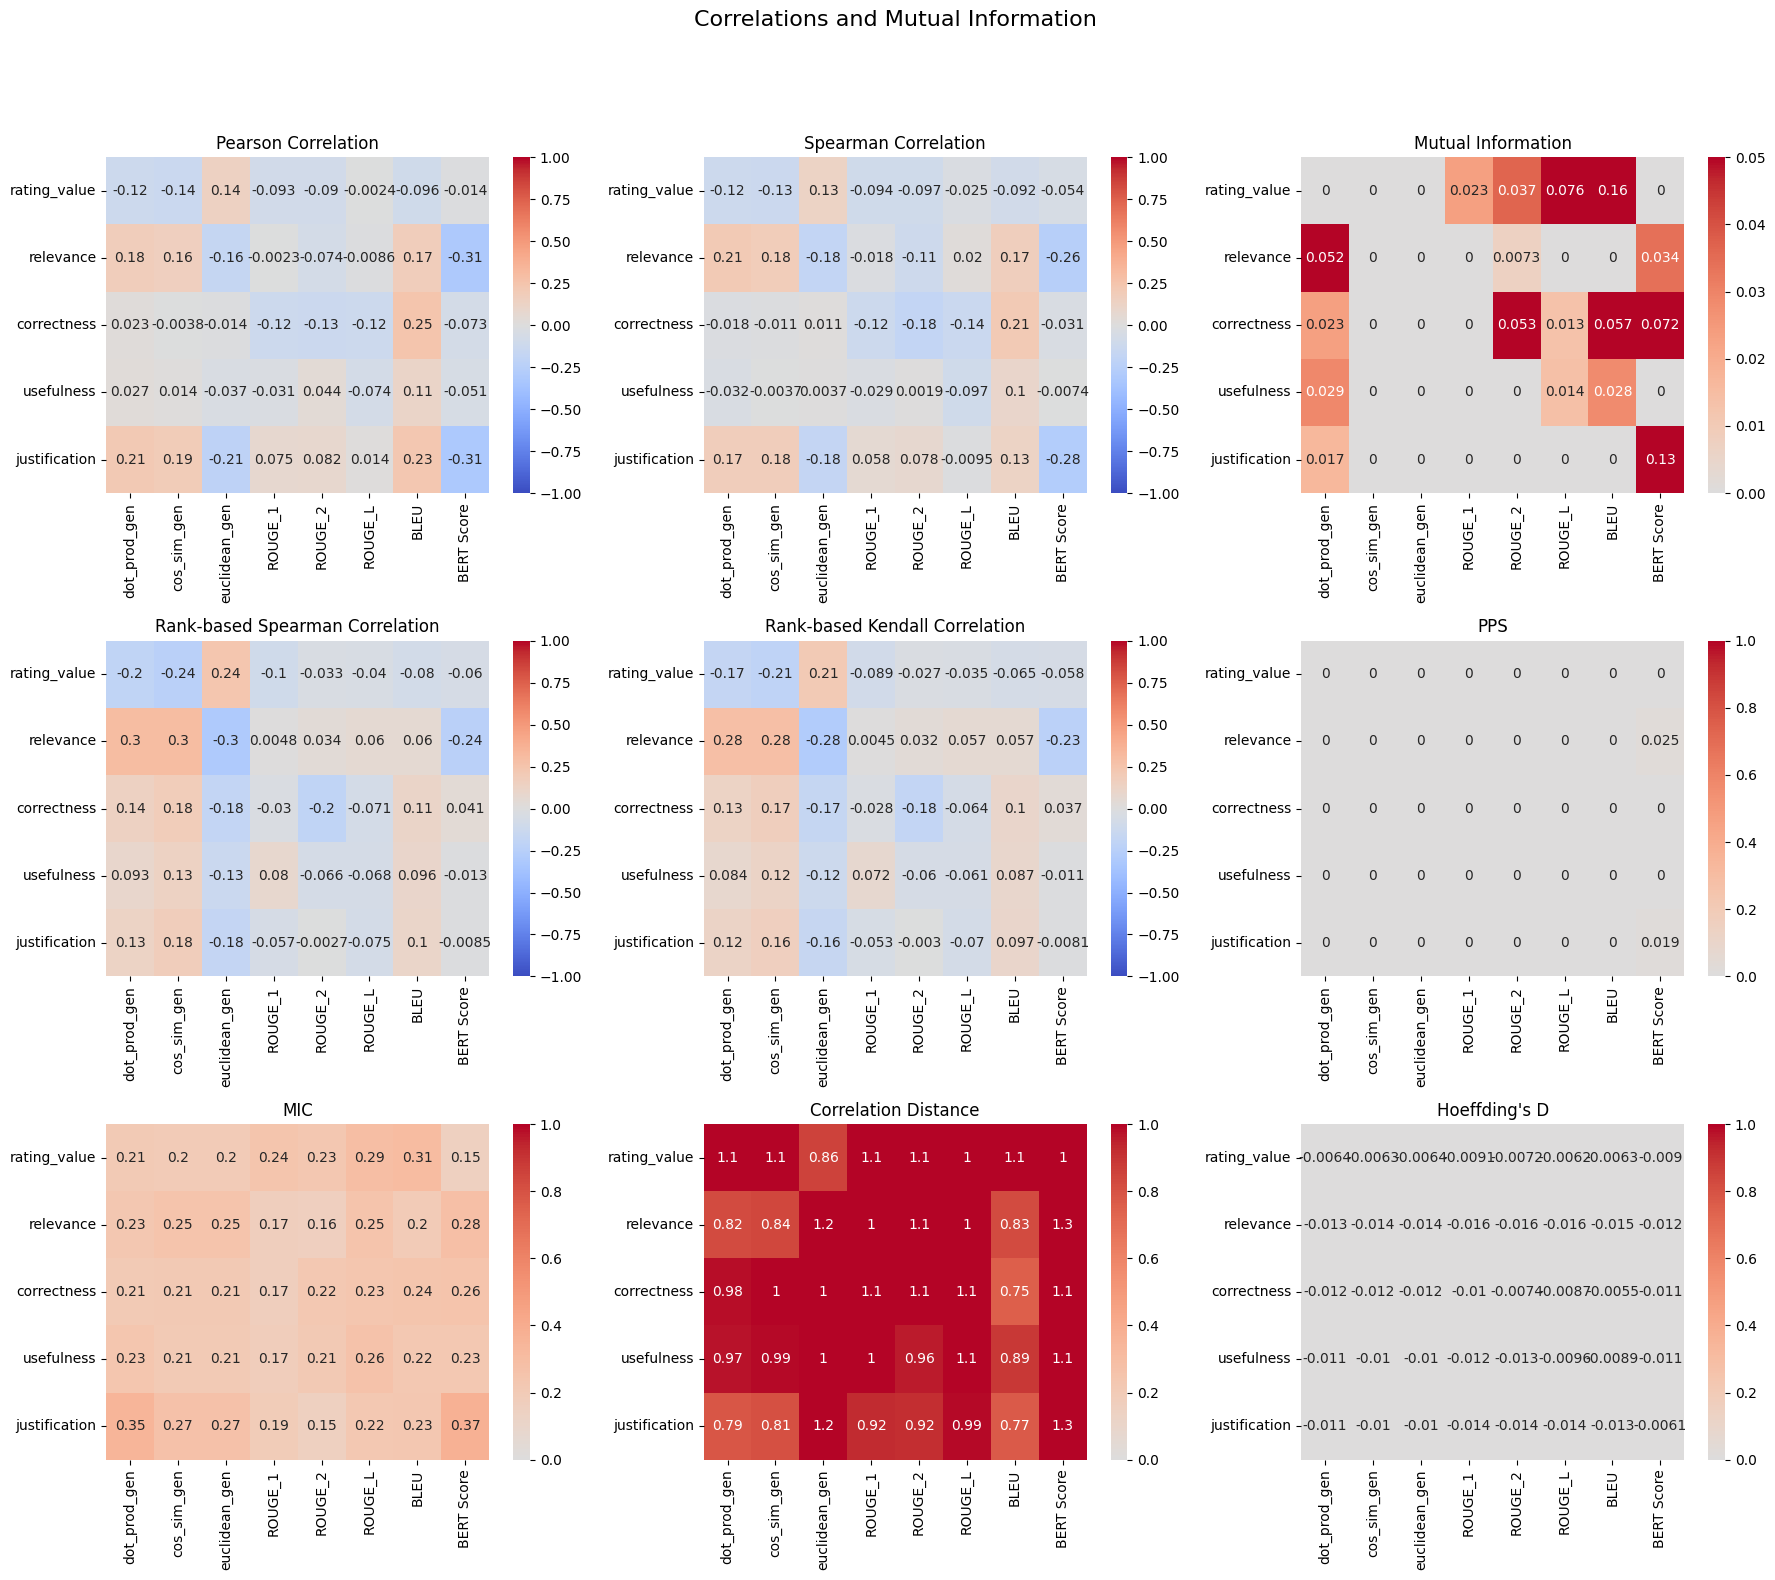

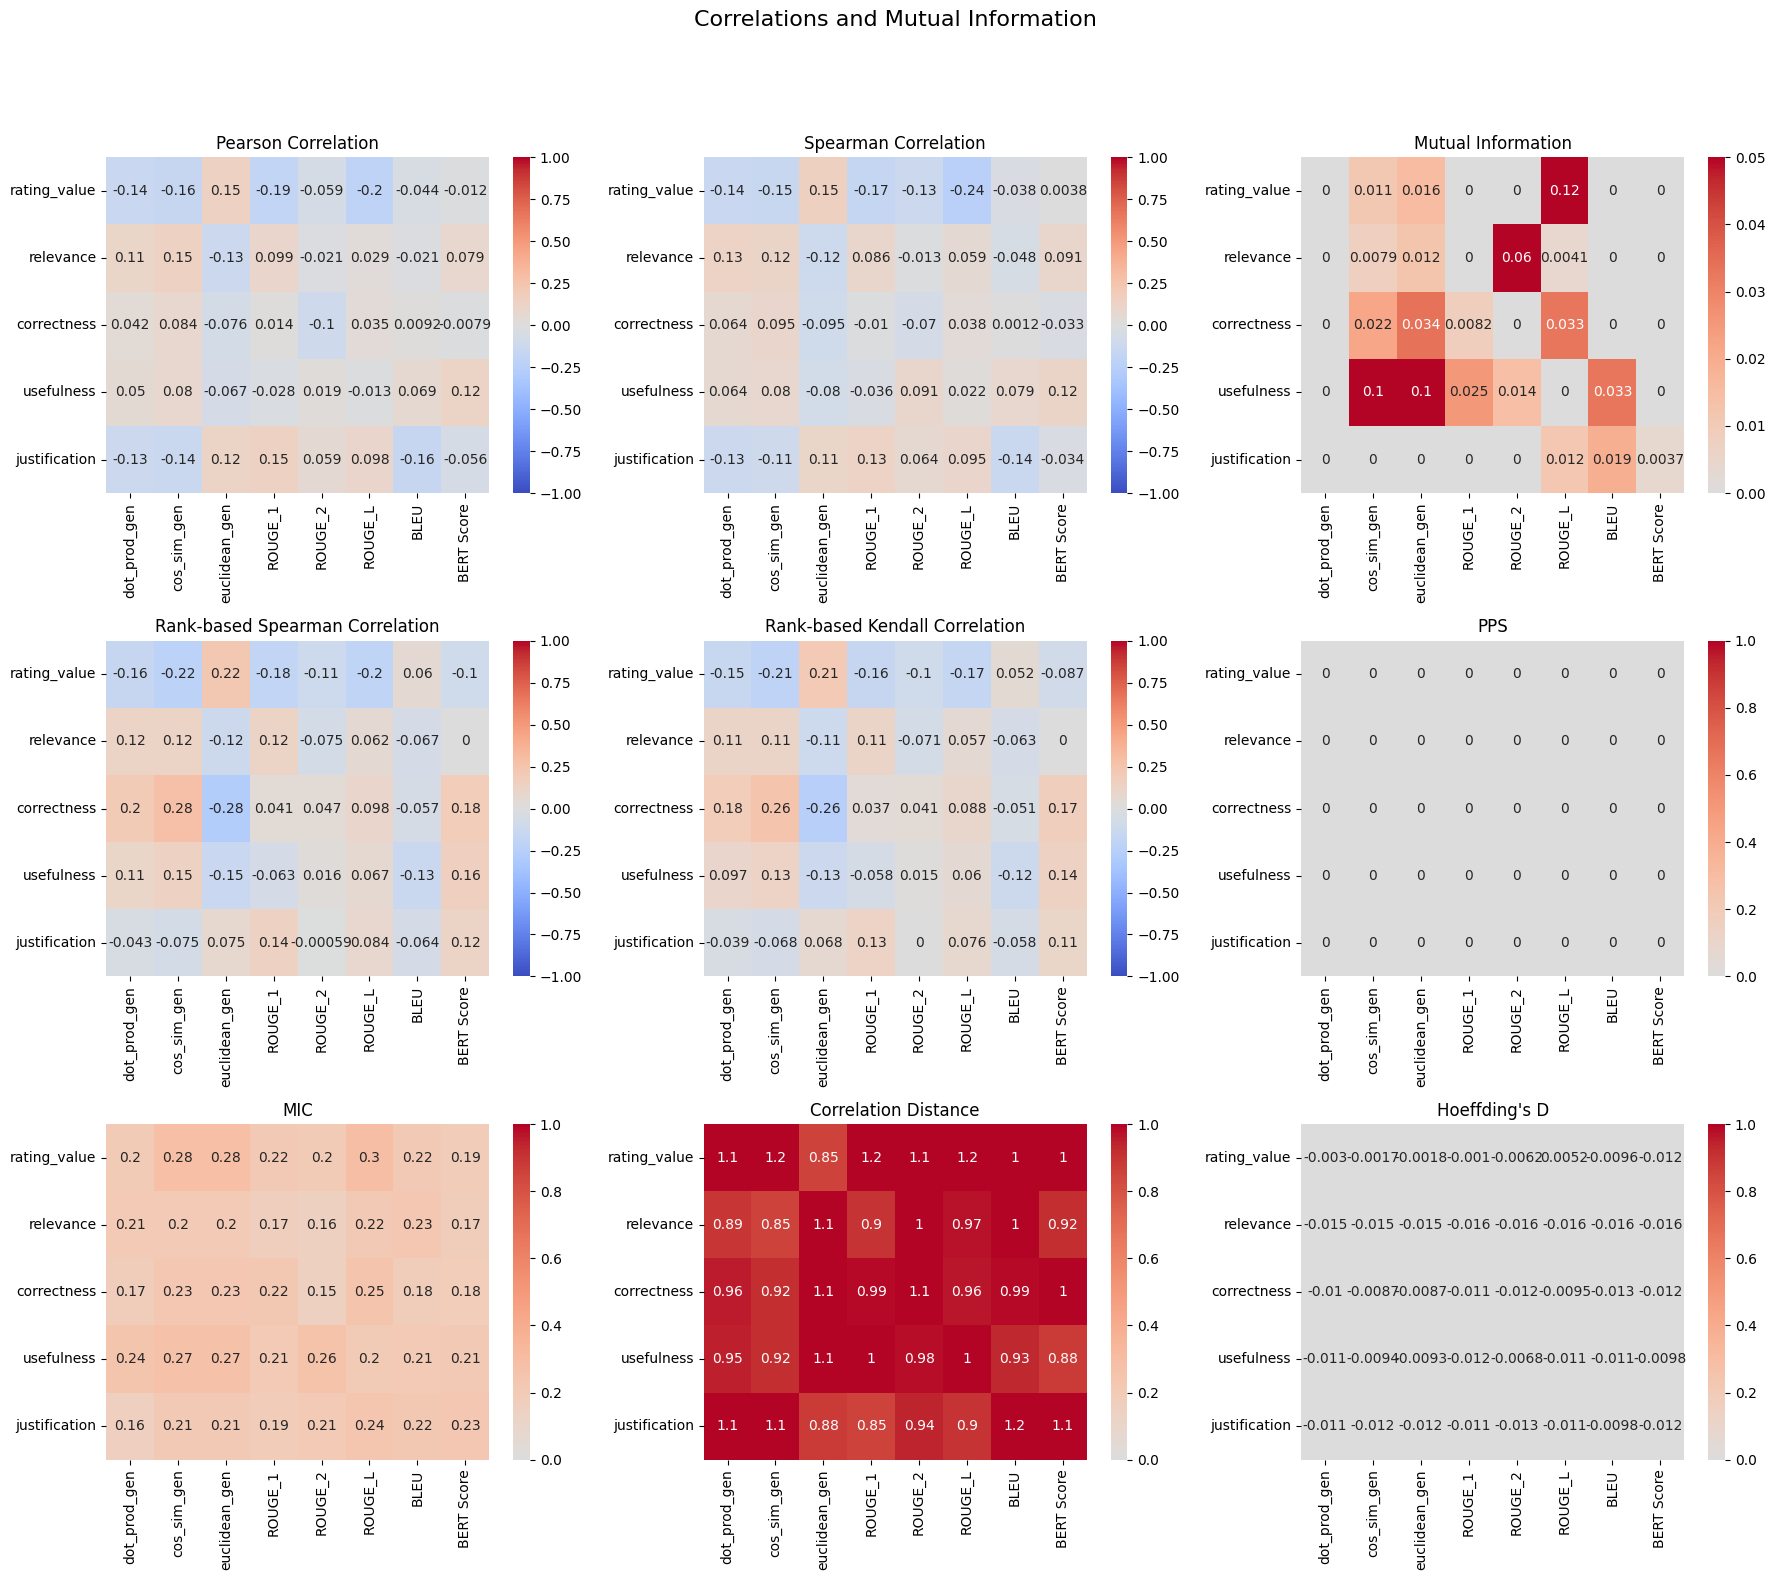

In [69]:
analyze_metrics(sft_so, predicted_metrics, linguistic_metrics)
analyze_metrics(sft_so_par, predicted_metrics, linguistic_metrics)
analyze_metrics(rlhf, predicted_metrics, linguistic_metrics)

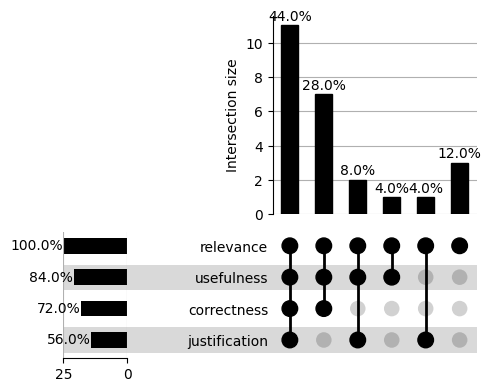

In [43]:
UpSet(
    from_indicators(base[bin_columns].astype(bool), data=base),
    sort_by="-degree",
    sort_categories_by="-cardinality",
    show_percentages=True,
    # show_counts=True,
    shading_color=0.15,
    # intersection_plot_elements=5
    # facecolor='red'
)

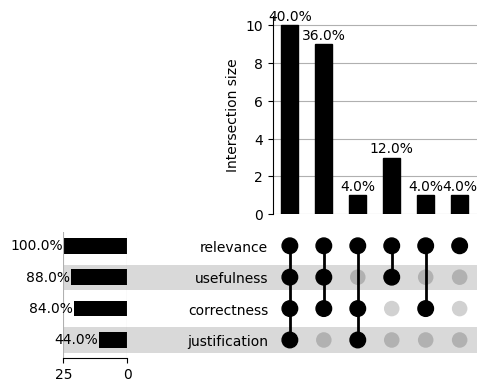

In [44]:
UpSet(
    from_indicators(sft_so[bin_columns].astype(bool), data=base),
    sort_by="-degree",
    sort_categories_by="-cardinality",
    show_percentages=True,
    # show_counts=True,
    shading_color=0.15,
    # intersection_plot_elements=5
    # facecolor='red'
)

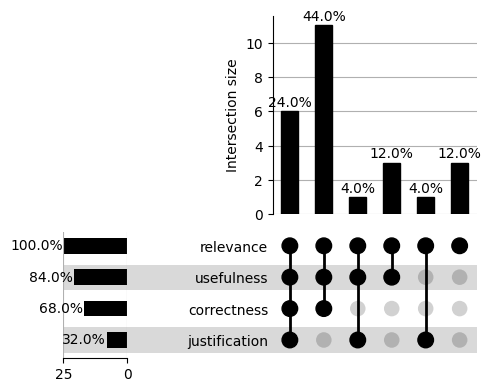

In [45]:
UpSet(
    from_indicators(sft_so_par[bin_columns].astype(bool), data=base),
    sort_by="-degree",
    sort_categories_by="-cardinality",
    show_percentages=True,
    # show_counts=True,
    shading_color=0.15,
    # intersection_plot_elements=5
    # facecolor='red'
)

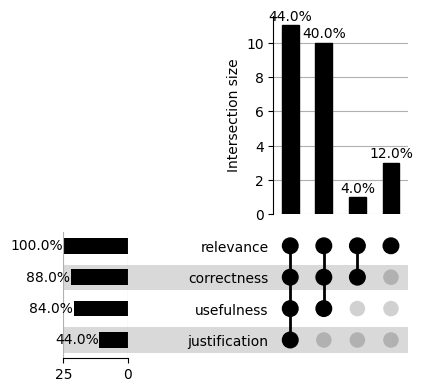

In [46]:
UpSet(
    from_indicators(rlhf[bin_columns].astype(bool), data=base),
    sort_by="-degree",
    sort_categories_by="-cardinality",
    show_percentages=True,
    # show_counts=True,
    shading_color=0.15,
    # intersection_plot_elements=5
    # facecolor='red'
)